In [1]:
import os
import numpy as  np
import matplotlib.pyplot as plt
import json
import config
from matplotlib.path import Path
import cv2


In [2]:
config.IMAGE_DIRECTORY

'/home/elmar/arduino_proj/cigarette_buts/out/image/buts'

In [3]:
def resize_image(directory):
    '''
    resizes the images in directory according to dimensions in the config file.
    Args: directory(str)
    
    '''
    for filename in os.listdir(directory):
        if filename.split('.')[1] == 'jpg':
            filename = os.path.join(directory , filename)
            img = cv2.imread(filename)
            img = cv2.resize(img , (config.IMG_HEIGHT , config.IMG_WIDTH))
            cv2.imwrite(filename , img)

In [4]:
def rename_files(file_directory):
    ''' 
    renames the file names in image directory in this format -> cgrt_0.jpg , cgrt_1.jpg .... 
    Args: file_directory 

    '''
    i = 1
    for filename in os.listdir(file_directory):
        if filename.split('.')[1] == 'jpg':
            filename = os.path.join(file_directory , filename)
            renamed_file = os.path.join(file_directory , f'cgrt_{i}.jpg')
            os.rename(filename , renamed_file)
            i+=1


In [5]:
def generate_mask(filename , json_file):
    '''
    generates a binary mask as ground truth for each image.
    Args: json_file
    '''

    with open(json_file, "r") as read_file:
        data = json.load(read_file)
    shapes = data['shapes']

    polygons = dict()
    for polygon_index in range(len(shapes)):
        polygons[polygon_index] = shapes[polygon_index]['points']
    
    for points in polygons:
        for index in range(len(polygons[points])):
            polygons[points][index][0] = round(polygons[points][index][0])
            polygons[points][index][1] = round(polygons[points][index][1]) 
            polygons[points][index] = tuple(polygons[points][index])

    print(polygons)
    x, y = np.meshgrid(np.arange(config.IMG_WIDTH), np.arange(config.IMG_HEIGHT))
    x, y = x.flatten(), y.flatten()
    points = np.vstack((x,y)).T
    grid = np.zeros(config.IMG_HEIGHT*config.IMG_WIDTH)
    for polygon in polygons:
        path = Path(polygons[polygon])
        grid = grid.astype(float)
        grid += path.contains_points(points).astype(float)
        
    grid = grid.reshape((config.IMG_HEIGHT, config.IMG_WIDTH))
    grid = grid.astype(bool).astype(float)

    mask_file_name = os.path.join(config.MASK_DIRECTORY, filename.split('.')[0])
    print(mask_file_name)
    np.save(mask_file_name , grid)



In [6]:
def crop_images(directory_path):
    '''
    for a given directory crop images from bottom to get rid of noise that we had because of camera.
    Args: directory_path(str)
    '''
    for image_path in os.listdir(directory_path):
        image_path = os.path.join(directory_path , image_path)
        _crop_images(image_path)



def _crop_images(image_path):
    '''
    for a given path crop image from bottom to get rid of noise that we had because of camera.
    Args: image_path(str)
    '''
    img = plt.imread(image_path)
    crop_img = img[:230, :] # [height , width]
    plt.imsave(image_path, crop_img)

In [7]:
def generate_img_over_bg(image_path , mask_path , bg_image_path):
    '''
    project a segmented objects over background image
    Args: image_path(str) , mask_path(str) , bg_image_path(str)
    '''
    img = plt.imread(image_path)
    mask = np.load(mask_path)
    bg_img = plt.imread(bg_image_path)

    positions = np.where(mask > 0)
    merged = np.zeros((config.IMG_HEIGHT , config.IMG_WIDTH , 3))
    merged = bg_img.copy()
    for pos_x , pos_y in zip(positions[0] , positions[1]):
        merged[pos_x , pos_y] = img[pos_x , pos_y]

    plt.imsave('../out/image/buts/merged_4.jpg' , merged)

In [8]:
crop_images('../out/image/bg')

In [9]:
rename_files(config.IMAGE_DIRECTORY)


In [10]:
resize_image(config.IMAGE_DIRECTORY)
resize_image(config.BACKGROUND_DIRECTORY)

In [11]:
generate_mask('cgrt_1.jpg', '../out/image/buts/cgrt_1.json')
generate_mask('cgrt_2.jpg', '../out/image/buts/cgrt_2.json')


{0: [(78, 99), (130, 204), (149, 181), (103, 80)]}
/home/elmar/arduino_proj/cigarette_buts/out/mask/cgrt_1
{0: [(46, 108), (64, 136), (73, 126), (55, 99)], 1: [(105, 34), (128, 45), (132, 32), (108, 27)], 2: [(148, 76), (167, 101), (176, 93), (155, 66)], 3: [(113, 105), (128, 140), (138, 131), (126, 100)], 4: [(147, 125), (156, 91), (166, 97), (158, 129)], 5: [(199, 121), (186, 143), (197, 151), (211, 125)], 6: [(165, 202), (188, 190), (194, 206), (168, 218)], 7: [(118, 212), (150, 225), (145, 240), (115, 230)]}
/home/elmar/arduino_proj/cigarette_buts/out/mask/cgrt_2


In [12]:
mask = np.load('../out/mask/cgrt_2.npy')
img = plt.imread("../out/image/buts/cgrt_2.jpg")

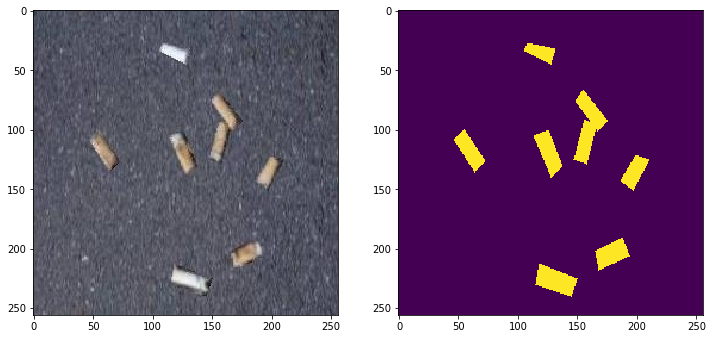

In [13]:
fig, ax = plt.subplots(1 , 2, figsize=(12, 8))
ax[0].imshow(img)
ax[1].imshow(mask)

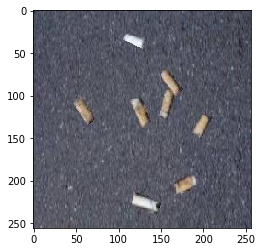

In [22]:
test = plt.imread('../out/image/buts/cgrt_2.jpg')
plt.imshow(test)

In [23]:
mask = np.load('../out/mask/cgrt_2.npy')
positions = np.where(mask > 0)
positions

(array([ 28,  28,  28, ..., 239, 239, 240]),
 array([108, 109, 110, ..., 144, 145, 145]))

In [24]:
new_img = np.zeros((256 , 256 , 3))

In [25]:
for pos_x , pos_y in zip(positions[0] , positions[1]):
    new_img[pos_x , pos_y] = img[pos_x , pos_y]
    
new_img = new_img.astype(np.uint8)
 # new_img[pos[0] , pos[1]]
    # print(pos_x , pos_y)


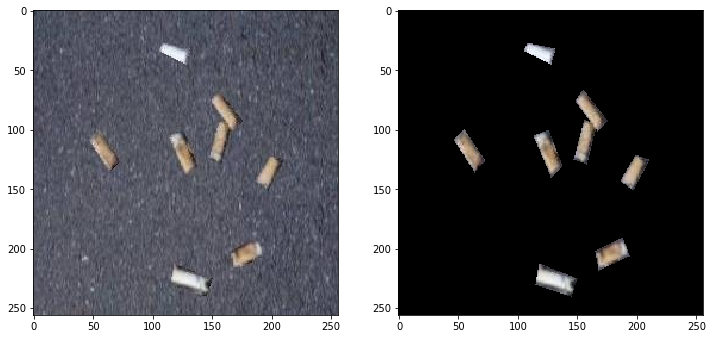

In [26]:
fig, ax = plt.subplots(1 , 2, figsize=(12, 8))
ax[0].imshow(img)
ax[1].imshow(new_img)

In [27]:
generate_img_over_bg('../out/image/buts/cgrt_2.jpg' ,'../out/mask/cgrt_2.npy' ,  '../out/image/bg/bg.jpg')

In [28]:
_crop_images('../out/image/bg/bg_1.jpg')